In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Cargar los datos
file_path = 'data/data.csv'

# Intentar cargar el archivo detectando automáticamente el delimitador
data = pd.read_csv(file_path, encoding='latin1', delimiter=';')

# Verificar las primeras filas
data.head()

,ID,Genero,Casado,Edad,Graduado,Profesion,Experiencia laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,Ingresos anuales brutos,Provincia,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno
0,CLI2,M,No,24,No,Funcionario,<10annos,Bajo,4,2000,Generacion Z,13945,Malaga,"1,029",30,0,278,NaN
1,CLI3,F,Si,42,Si,Ingeniero,+20annos,Medio,3,1982,Millennials,118107,Salamanca,"1,79",30,0,455,3
2,CLI4,F,Si,74,Si,Ingeniero,+20annos,Bajo,1,1950,Generacion X,53533,Burgos,"1,326",50,0,380,1
3,CLI5,M,Si,74,Si,Servicios,+20annos,Alto,2,1950,Generacion X,82273,Gerona,"0,779",50,1,387,3
4,CLI6,F,Si,44,Si,Otros,+20annos,Alto,6,1980,Generacion X,90776,ivila,"1,767",30,1,299,NaN


## Limpieza de datos

In [3]:
# 1. Manejo de valores faltantes
data.fillna(data.mode().iloc[0], inplace=True)  # Rellenar con la moda para datos categóricos y nulos

In [4]:
# 2. Codificación de variables categóricas
categorical_columns = ['Genero', 'Casado', 'Graduado', 'Profesion', 'Experiencia laboral', 
                       'Gastoscore', 'Generacion', 'Provincia']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [5]:
# Reemplazar comas por puntos y convertir a float
columns_to_fix = ['Ingresos anuales brutos', 'Digital_encuesta', 'Gasto_medio_mensual_cuota']

for col in columns_to_fix:
    data_encoded[col] = data_encoded[col].astype(str).str.replace(',', '.').astype(float)

In [6]:
# 3. Escalamiento de variables numéricas
numeric_columns = ['Edad', 'Family_Size', 'anno_nacimiento', 'Ingresos anuales brutos', 
                   'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Dias_cliente']
scaler = StandardScaler()
data_encoded[numeric_columns] = scaler.fit_transform(data_encoded[numeric_columns])

In [7]:
# Identificar columnas que requieren conversión (si contienen valores con comas)
for col in data_encoded.columns:
    if data_encoded[col].dtype == 'object':  # Revisar columnas tipo string
        try:
            data_encoded[col] = data_encoded[col].astype(str).str.replace(',', '.').astype(float)
        except ValueError:
            # Si no se pueden convertir, ignorar (probablemente no sean columnas numéricas)
            pass

In [8]:
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=10)  # Reducir a 10 componentes principales
X_pca = pca.fit_transform(data_encoded.drop(['ID', 'Abandono'], axis=1, errors='ignore'))

In [9]:
num_clusters = 5

In [11]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [12]:
# Método del Codo para determinar el número óptimo de clusters
inertia = []
cluster_range = range(1, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

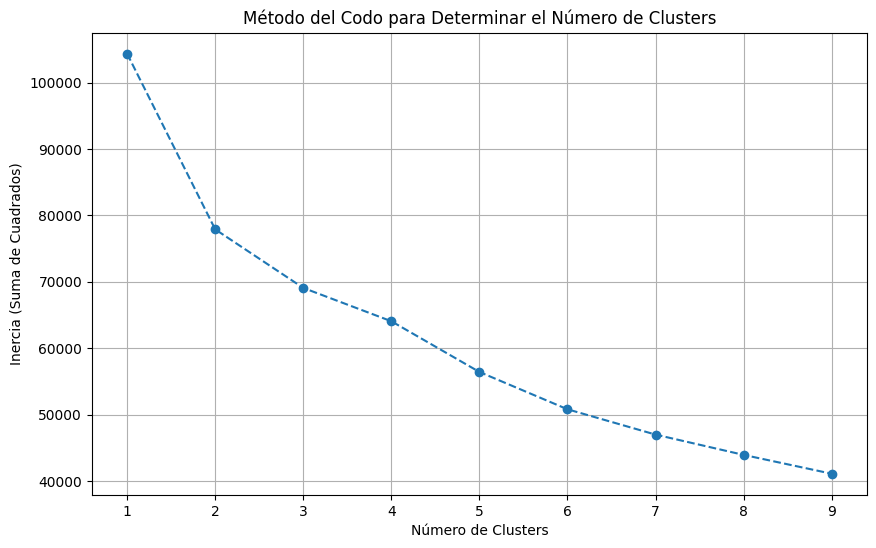

In [13]:
# Graficar el método del Codo
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia (Suma de Cuadrados)')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.grid(True)
plt.show()

In [14]:
# Agregar los clusters al conjunto de datos original
data['Cluster'] = clusters

In [15]:
# Guardar los resultados en un nuevo archivo
data.to_csv(f'data/clientes_segmentados_{num_clusters}clusters.csv', index=False)
print(f"Segmentación completada. Resultados guardados en 'clientes_segmentados_{num_clusters}clusters.csv'.")

Segmentación completada. Resultados guardados en 'clientes_segmentados_5clusters.csv'.


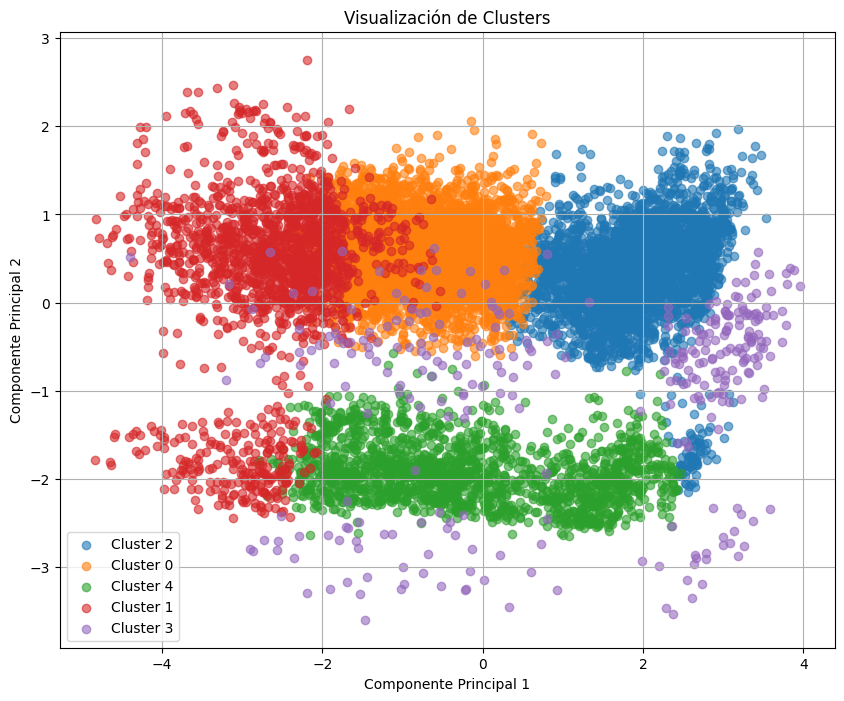

In [16]:
# Reducir a 2 componentes principales para visualización
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(data_encoded.drop(['ID', 'Abandono', 'Cluster'], axis=1, errors='ignore'))

# Crear un DataFrame con los clusters y las componentes principales
clustered_data = pd.DataFrame(X_pca_2d, columns=['PCA1', 'PCA2'])
clustered_data['Cluster'] = data['Cluster']

# Graficar los clusters
plt.figure(figsize=(10, 8))
for cluster in clustered_data['Cluster'].unique():
    cluster_points = clustered_data[clustered_data['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Visualización de Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()
